In [ ]:
'Notebook um sich die Daten genauer anzuschauen'
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
from wettbewerb import load_references, get_3montages
import mne
from scipy import signal as sig
import preprocess
import importlib
import features

In [ ]:
train_folder = "../shared_data/training_mini"

In [ ]:
ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(train_folder)

In [ ]:
reference_channels = channels[0]  # Use the first sample as reference
all_same = True  # Flag to track if all are the same

for i, ch in enumerate(channels):
    if ch != reference_channels:
        all_same = False
        print(f"Sample ID {ids[i]} has different channels.")
        extra = set(ch) - set(reference_channels)
        missing = set(reference_channels) - set(ch)
        if extra:
            print(f"  Extra channels: {extra}")
        if missing:
            print(f"  Missing channels: {missing}")

if all_same:
    print("Every sample has the same channels.")
    print(reference_channels)
    print(len(reference_channels))

In [ ]:
import CNN_dataset
from wettbewerb import load_references, get_3montages
import os

train_folder = "../shared_data/training"
files = [f for f in os.listdir(train_folder) if f.endswith('.mat')]
n_files = len(files)
print(f"found {n_files} files")

index = 0
for i in range(0, n_files, 100):
    ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(train_folder, i)
    CNN_dataset.create_cnn_dataset_map(ids, channels, data, sampling_frequencies, reference_systems, eeg_labels, i)
    print(f"created dataset {index}")
    index = index + 1

In [ ]:

import numpy as np
import json
import os
from typing import List, Tuple, Dict, Any
from wettbewerb import get_3montages

# Pakete aus dem Vorlesungsbeispiel
import mne
from scipy import signal as sig
import ruptures as rpt
import torch 
import torch.nn as nn
from CNN_model import CNN_EEG
from preprocess import process_without_mne
from features import feature_extraction
from CNN_dataset import window_data_evaluate, create_fixed_grid_maps
from glob import glob

###Signatur der Methode (Parameter und Anzahl return-Werte) darf nicht verändert werden
def predict_labels(channels : List[str], data : np.ndarray, fs : float, reference_system: str, model_name : str='model.json') -> Dict[str,Any]:
    '''
    Parameters
    ----------
    channels : List[str]
        Namen der übergebenen Kanäle
    data : ndarray
        EEG-Signale der angegebenen Kanäle
    fs : float
        Sampling-Frequenz der Signale.
    reference_system :  str
        Welches Referenzsystem wurde benutzt, "Bezugselektrode", nicht garantiert korrekt!
    model_name : str
        Name eures Models,das ihr beispielsweise bei Abgabe genannt habt. 
        Kann verwendet werden um korrektes Model aus Ordner zu laden
    Returns
    -------
    prediction : Dict[str,Any]
        enthält Vorhersage, ob Anfall vorhanden und wenn ja wo (Onset+Offset)
    '''

#------------------------------------------------------------------------------
# Euer Code ab hier  

    # Initialisiere Return (Ergebnisse)
    seizure_present = True # gibt an ob ein Anfall vorliegt
    seizure_confidence = 0.5 # gibt die Unsicherheit des Modells an (optional)
    onset = 4.2   # gibt den Beginn des Anfalls an (in Sekunden)
    onset_confidence = 0.99 # gibt die Unsicherheit bezüglich des Beginns an (optional)
    offset = 999999  # gibt das Ende des Anfalls an (optional)
    offset_confidence = 0   # gibt die Unsicherheit bezüglich des Endes an (optional)

    # Modell Aufsetzen
    #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    device = torch.device("cpu")
    '''
    model = torch.load(model_name, map_location=device)
    model.to(device)
    model.eval()
    '''
    #Daten vorbereiten
    window_size = 4.0
    step_size = 1
    standard_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
    n_nodes = len(standard_channels)

    processed_input = process_without_mne(data, fs, channels, reference_system, fs)
    
    channel_map = {ch: idx for idx, ch in enumerate(channels)}
    pad_data = np.zeros((n_nodes, processed_input.shape[1]))
    for j, ch in enumerate(standard_channels):
        if ch in channel_map:
            pad_data[j] = processed_input[channel_map[ch]]
    
    windows = window_data_evaluate(pad_data, fs, window_size, step_size)
    data_for_class = []
    # Feature extraction and brain map calculation
    for win in windows:
        features = feature_extraction(win, fs) # shape: (n_channels, n_features)
        assert not np.isnan(features).any(), "NaN in features!"
        brain_map = create_fixed_grid_maps(features, channels)
        assert not np.isnan(brain_map).any(), "NaN in brain_map!"
        x = torch.tensor(brain_map, dtype = torch.float)
        data_for_class.append(x)
        

    # Klassifikation
    predictions_per_window =[]
    with torch.no_grad():
        for feature_map in data_for_class:
            feature_map = feature_map.unsqueeze(0).to(device)
            #output = model(feature_map)
            #predicted_class = torch.argmax(output, dim=1).item()
            predicted_class = predictions_ensemble(feature_map,model_name,device)
            predictions_per_window.append(predicted_class)
    
    seizure_present = False
    '''
    if 1 in predictions_per_window:
        seizure_present = True
        first_idx = predictions_per_window.index(1)
        time_first = first_idx * step_size
        onset = time_first
    '''
    for i in range(len(predictions_per_window) - 1):
        if predictions_per_window[i] == 1 and predictions_per_window[i + 1] == 1:
            seizure_present = True
            time_first = i * step_size
            onset = time_first
            break
    '''
    # Hier könnt ihr euer vortrainiertes Modell laden (Kann auch aus verschiedenen Dateien bestehen)
    model = MyCNN()
    model.load_state_dict(torch.load(model_name, map_location='cpu'))
    model.eval()

    
    # Wende Beispielcode aus Vorlesung an 
    
    _montage, _montage_data, _is_missing = get_3montages(channels, data)
    signal_std = np.zeros(len(_montage))
    for j, signal_name in enumerate(_montage):
        # Ziehe erste Montage des EEG
        signal = _montage_data[j]
        # Wende Notch-Filter an um Netzfrequenz zu dämpfen
        signal_notch = mne.filter.notch_filter(x=signal, Fs=fs, freqs=np.array([50.,100.]), n_jobs=2, verbose=False)
        # Wende Bandpassfilter zwischen 0.5Hz und 70Hz um Rauschen aus dem Signal zu filtern
        signal_filter = mne.filter.filter_data(data=signal_notch, sfreq=fs, l_freq=0.5, h_freq=70.0, n_jobs=2, verbose=False)
        
        # Berechne short time fourier transformation des Signal: signal_filtered = filtered signal of channel, fs = sampling frequency, nperseg = length of each segment
        # Output f= array of sample frequencies, t = array of segment times, Zxx = STFT of signal
        f, t, Zxx = sig.stft(signal_filter, fs, nperseg=fs * 3)
        # Berechne Schrittweite der Frequenz
        df = f[1] - f[0]
        # Berechne Engergie (Betrag) basierend auf Real- und Imaginärteil der STFT
        E_Zxx = np.sum(Zxx.real ** 2 + Zxx.imag ** 2, axis=0) * df
        
        signal_std[j] = np.std(signal_filter)



        # Erstelle neues Array in der ersten Iteration pro Patient
        if j == 0:
            # Initilisiere Array mit Energiesignal des ersten Kanals
            E_array = np.array(E_Zxx)
        else:
            # Füge neues Energiesignal zu vorhandenen Kanälen hinzu (stack it)
            E_array = np.vstack((E_array, np.array(E_Zxx)))
            
    # Berechne Feature zur Seizure Detektion
    signal_std_max = signal_std.max()
    # Klassifiziere Signal
    seizure_present = signal_std_max>th_opt
    
    # Berechne Gesamtenergie aller Kanäle für jeden Zeitppunkt
    E_total = np.sum(E_array, axis=0)
    # Berechne Stelle der maximalen Energie
    max_index = E_total.argmax()

    # Berechne "changepoints" der Gesamtenergie
    # Falls Maximum am Anfang des Signals ist muss der Onset ebenfalls am Anfang sein und wir können keinen "changepoint" berechnen
    if max_index == 0:
        onset = 0.0
        onset_confidence = 0.2
        
    else:
        # Berechne "changepoint" mit dem ruptures package
        # Setup für  "linearly penalized segmentation method" zur Detektion von changepoints im Signal mi rbf cost function
        algo = rpt.Pelt(model="rbf").fit(E_total)
        # Berechne sortierte Liste der changepoints, pen = penalty value
        result = algo.predict(pen=10)
        #Indices sind ums 1 geshiftet
        result1 = np.asarray(result) - 1
        # Selektiere changepoints vor Maximum
        result_red = result1[result1 < max_index]
        # Falls es mindestens einen changepoint gibt nehmen wir den nächsten zum Maximum
        if len(result_red)<1:
            # Falls keine changepoint gefunden wurde raten wir, dass er "nahe" am Maximum ist
            print('No changepoint, taking maximum')
            onset_index = max_index
        else:
            # Der changepoint entspricht gerade dem Onset 
            onset_index = result_red[-1]
        # Gebe Onset zurück
        onset = t[onset_index]      
     
     
    '''
#------------------------------------------------------------------------------  
    prediction = {"seizure_present":seizure_present,"seizure_confidence":seizure_confidence,
                   "onset":onset,"onset_confidence":onset_confidence,"offset":offset,
                   "offset_confidence":offset_confidence}
  
    return prediction # Dictionary mit prediction - Muss unverändert bleiben!
                               
                               
        
def predictions_ensemble(feature,model_name,device):
    
    file_paths = sorted([os.path.join(model_name, f) for f in os.listdir(model_name) if f.endswith(".pth")])

    probas = torch.zeros(2).to(device)  # 2 Klassen
    with torch.no_grad():
        for path in file_paths:
            model = torch.load(path, map_location=device)
            model.eval()
            output = model(feature)  # shape: [1, 2]
            probas += torch.softmax(output.squeeze(), dim=0)  # → shape: [2]

    prediction = probas / len(file_paths)  # shape: [2]
    y_pred = (prediction[1] > 0.5).long()  # ← sicher!
    return y_pred


In [ ]:
import CNN_dataset
from wettbewerb import load_references, get_3montages
import os

ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references("../shared_data/training_mini", 99)
print(predict_labels(channels[0],data[0],sampling_frequencies[0],reference_systems[0],"models_strat"))

In [ ]:
import CNN_dataset
from wettbewerb import load_references, get_3montages
import os

train_folder = "../shared_data/training"
files = [f for f in os.listdir(train_folder) if f.endswith('.mat')]
n_files = len(files)
print(f"found {n_files} files")

index = 0
for i in range(0, n_files, 100):
    ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(train_folder, i)
    CNN_dataset.create_cnn_dataset_map(ids, channels, data, sampling_frequencies, reference_systems, eeg_labels, i)
    print(f"created dataset {index}")
    index = index + 1

In [ ]:
from wettbewerb import load_references
import os
import pandas as pd
import scipy.signal as signal
import numpy as np

train_folder = "../shared_data/training"

files = [f for f in os.listdir(train_folder) if f.endswith('.mat')]
n_files = len(files)

print(f"found {n_files} files")

index = 0
positive_data = []
for i in range(0, n_files, 100):
    ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(train_folder, i)
    df = pd.DataFrame({
    'ids': ids,  
    'channels': channels,
    'data': data,
    'fs' : sampling_frequencies,
    'ref' : reference_systems,
    'label' : eeg_labels
    })
    
    df_label_1 = df[df['label'].apply(lambda x: x[0] == 1)]
    positive_data.append(df_label_1)
    index = index +1
    
df_label_1_gesamt = pd.concat(positive_data, ignore_index=True)
df_label_1_gesamt.to_pickle("positive_daten.pkl")

df = pd.read_pickle("positive_daten.pkl")
min_fs = df['fs'].min()
for i, row in df.iterrows():
    orig_fs = row['fs']
    new_data = []
    if orig_fs > min_fs:
        for ind, channel in enumerate(row['data']):
            orig_len = len(channel)

            new_len = int(orig_len * min_fs / orig_fs)
            new_channel = sc.signal.resample(channel, new_len)
            new_data.append(new_channel)
        df.at[i, 'data'] = np.asarray(new_data)
        df.at[i, 'fs'] = min_fs 
    

nyq = 0.5 * min_fs
low = 1 / nyq
high = 120 / nyq
b, a = signal.butter(4, [low, high], btype='band')

w0 = 60 / (min_fs / 2)  # Normierte Frequenz
b1, a1 = signal.iirnotch(w0, 30)

for i, row in df.iterrows():
    orig_data = row['data']
    band_data = signal.filtfilt(b,a,orig_data)
    notch_data = signal.filtfilt(b1,a1,band_data)
    df.at[i, 'data'] = notch_data
    
df.to_pickle("positive_filtered.pkl")

In [ ]:
df = pd.read_pickle("positive_filtered.pkl")
print(df.shape)
df.to_csv("pos.csv")

In [ ]:
import pandas as pd
import scipy.signal as signal

df = pd.read_csv("positive_daten.csv")
min_fs = df['fs'].min()
for i, row in df.iterrows():
    orig_fs = row['fs']
    if orig_fs > min_fs:
        orig_data = row['data']
        orig_len = len(orig_data)
        
        new_len = int(orig_len * min_fs / orig_fs)
        new_data = sc.signal.resample(orig_data, new_len)
        df.at[i, 'data'] = new_data
        df.at[i, 'fs'] = min_fs 
    

nyq = 0.5 * min_fs
low = 1 / nyq
high = 120 / nyq
b, a = signal.butter(4, [low, high], btype='band')

w0 = 60 / (min_fs / 2)  # Normierte Frequenz
b1, a1 = signal.iirnotch(w0, 30)

for i, row in df.iterrows():
    orig_data = row['data']
    band_data = signal.filtfilt(b,a,orig_data)
    notch_data = signal.filtfilt(b1,a1,band_data)
    df.at[i, 'data'] = notch_data
    
df_label_1_gesamt.to_csv("positive_filtered.csv", index=False)


In [ ]:
df = pd.read_csv("positive_daten.csv")
print(df.shape)


In [3]:
from wettbewerb import load_references
import os
import pandas as pd
import scipy.signal as signal
import numpy as np

# Daten laden
df = pd.read_pickle("positive_daten.pkl")
print(f"Original shape: {df.shape}")

# Ziel-Samplingrate
min_fs = 100

# Resampling
for i, row in df.iterrows():
    orig_fs = row['fs']
    if orig_fs > min_fs:
        new_data = []
        for channel in row['data']:
            new_len = int(len(channel) * min_fs / orig_fs)
            new_channel = signal.resample(channel, new_len)
            new_data.append(new_channel)
        df.at[i, 'data'] = np.asarray(new_data)
        df.at[i, 'fs'] = min_fs

# Bandpass-Grenzen anpassen
nyq = 0.5 * min_fs
lowcut = 1
highcut = min(120, nyq - 1)  # muss < nyq bleiben
low = lowcut / nyq
high = highcut / nyq

# Filter entwerfen
b_band, a_band = signal.butter(4, [low, high], btype='band')


# Filter anwenden
for i, row in df.iterrows():
    data = row['data']  # shape: (channels, samples)
    band_data = signal.filtfilt(b_band, a_band, data, axis=1)
    df.at[i, 'data'] = band_data

# Speichern
df.to_pickle("positive_filtered_100Hz.pkl")
print("Gefilterte Daten gespeichert unter: positive_filtered_100Hz.pkl")


Original shape: (2421, 6)
Gefilterte Daten gespeichert unter: positive_filtered_100Hz.pkl


In [ ]:
import pandas as pd
df = pd.read_pickle("positive_daten.pkl")
print(df.shape)
print(df.loc[1, 'data'].shape)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hole Daten und Sampling-Rate
data = df.loc[1, 'data']       # shape: (channels, samples)
fs = df.loc[1, 'fs']           # Sampling-Rate in Hz

channels, samples = data.shape
t = np.arange(samples) / fs    # Zeitachse (optional)

# Frequenzachse für FFT
freqs = np.fft.rfftfreq(samples, d=1/fs)

# Erzeuge das Plot-Fenster
plt.figure(figsize=(12, 6))

# Für jeden Kanal das Spektrum berechnen und plotten
for ch in range(channels):
    signal = data[ch]
    fft_vals = np.fft.rfft(signal)
    magnitude = np.abs(fft_vals)
    plt.plot(freqs, magnitude, label=f'Kanal {ch}')

plt.title('Frequenzspektrum pro Kanal')
plt.xlabel('Frequenz [Hz]')
plt.ylabel('Amplitude')

plt.ylim(0,0.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import CNN_dataset
from wettbewerb import load_references, get_3montages
import os

train_folder = "../shared_data/training"
files = [f for f in os.listdir(train_folder) if f.endswith('.mat')]
n_files = len(files)

print(f"found {n_files} files")
window_configs = [(5,5),(10,10),(10,5),(20,20),(20,10),(30,30),(30,15),(60,60),(60,30)]
index = 0
for i in range(0, n_files, 100):
    ids, channels, data, sampling_frequencies, reference_systems, eeg_labels = load_references(train_folder, i)
    CNN_dataset.create_multiple_cnn_datasets(ids, channels, data, sampling_frequencies, reference_systems, eeg_labels,index,window_configs, base_output_dir="datasets")
    print(f"\n created datasets {index}")
    index = index + 1
    
    


🔍 Found 63 files.
Convert to numpy arrays
Compute means


NameError: name 'im' is not defined

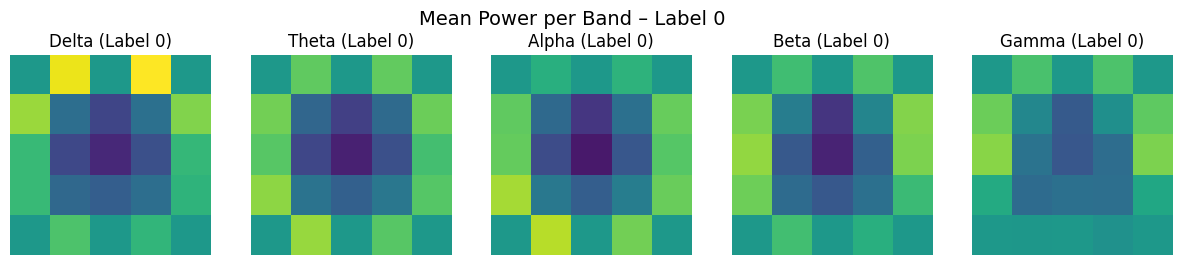

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Dataset path
test_dataset = "datasets/win10_step10"
file_paths = sorted(glob(os.path.join(test_dataset, "*.pt")))
print(f"🔍 Found {len(file_paths)} files.")

power_data_label0 = []
power_data_label1 = []

for file_path in file_paths:
    data = torch.load(file_path)
    for x, y, gruppe in data:
        power = x[:6].numpy()  # shape: (5, 5, 5)
        if y.item() == 0:
            power_data_label0.append(power)
        elif y.item() == 1:
            power_data_label1.append(power)
print("Convert to numpy arrays")
# Convert to numpy arrays
power_array_0 = np.stack(power_data_label0) if power_data_label0 else np.empty((0, 5, 5, 5))
power_array_1 = np.stack(power_data_label1) if power_data_label1 else np.empty((0, 5, 5, 5))
print("Compute means")
# Compute means
mean_power_0 = np.mean(power_array_0, axis=0) if len(power_array_0) > 0 else None
mean_power_1 = np.mean(power_array_1, axis=0) if len(power_array_1) > 0 else None

# Shared color scale
vmin = min(np.min(mean_power_0), np.min(mean_power_1))
vmax = max(np.max(mean_power_0), np.max(mean_power_1))

bands = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

# Plot label 0
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(mean_power_0[i], cmap="viridis", vmin=vmin, vmax=vmax)
    plt.title(f"{bands[i]} (Label 0)")
    plt.axis("off")
plt.suptitle("Mean Power per Band – Label 0", fontsize=14)
plt.colorbar(im, ax=plt.gcf().axes, shrink=0.6)
plt.tight_layout()
plt.show()

# Plot label 1
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(mean_power_1[i], cmap="viridis", vmin=vmin, vmax=vmax)
    plt.title(f"{bands[i]} (Label 1)")
    plt.axis("off")
plt.suptitle("Mean Power per Band – Label 1", fontsize=14)
plt.colorbar(im, ax=plt.gcf().axes, shrink=0.6)
plt.tight_layout()
plt.show()

In [ ]:
import pickle
import pandas as pd
# Load the DataFrame
df = pd.read_pickle('positive_filtered.pkl')

# Display basic info
print(df.info())     # Column types, non-null counts
print(df.head())     # First few rows

In [ ]:
df[['class', 'onset_time', 'end_time']] = pd.DataFrame(df['label'].tolist(), index=df.index)
df['onset_sample'] = (df['onset_time'] * df['fs']).astype(int)
MAX_LEN = 1000
N_CHANNELS = 19
import numpy as np

def pad_data(x, max_len=MAX_LEN, n_channels=N_CHANNELS):
    x = np.array(x)
    
    # Fix shape if needed
    if x.ndim != 2:
        x = np.atleast_2d(x)
    
    # Ensure correct number of channels
    if x.shape[0] != n_channels:
        raise ValueError(f"Expected {n_channels} channels, got {x.shape[0]}")
    
    # Pad or truncate time dimension
    if x.shape[1] > max_len:
        x = x[:, :max_len]
    elif x.shape[1] < max_len:
        pad_width = max_len - x.shape[1]
        x = np.pad(x, ((0, 0), (0, pad_width)), mode='constant')
    
    return x
df_consistent = df[df['data'].apply(lambda x: np.array(x).shape[0] == 19)].reset_index(drop=True)
X = np.stack(df_consistent['data'].apply(lambda x: pad_data(x)))
y = df_consistent['onset_sample'].values
X = np.transpose(X, (0, 2, 1))  # (samples, time, channels)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
import torch
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        return self.fc(out).squeeze()

model = LSTMRegressor(input_size=X.shape[2])

from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}")
    
model.eval()
with torch.no_grad():
    preds = model(torch.tensor(X_test, dtype=torch.float32)).numpy()
    mse = ((preds - y_test) ** 2).mean()
    print(f"Test MSE: {mse:.2f}")

    i = 0  # index of a sample to plot
signal = X_test[i]  # shape: (time, channels)
signal_ch0 = signal[:, 0]  # visualize one channel

true_onset = int(y_test[i])
pred_onset = int(preds[i])

plt.figure(figsize=(12, 4))
plt.plot(signal_ch0, label='EEG Channel 0')
plt.axvline(true_onset, color='green', linestyle='--', label='True Onset')
plt.axvline(pred_onset, color='red', linestyle='--', label='Predicted Onset')
plt.legend()
plt.title("EEG Signal with True vs. Predicted Onset")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()